## Name - Procurement Strategies - XGGZ9 Student
***UCL Business Analytics Course Final Thesis Notebook***

----

### Summary

The following notebook illustrates three aluminium raw material purchasing strategies for company ABC (annoymised company name) by utilising the aluminium pricing engine built out in the code repo.

Purchasing approach utilising aluminium pricing engine exhibits the highest value in increasing profit compared to others. Detailed below are summaries of the approach and the impact assessment.

### Three Approaches

1. **Baseline**: 
    - Purchase Aluminium on a daily basis where the purchase amount is average daily aluminium usage in the past year
    
2. **Arbitrary**:
    - Utilising the Aluminium pricing prediction engine to predict the one-month-low day for the month. The purchase amount is the same as the usage in the next month
    
    
3. **Refined Strategy**: 
    - Utilising the following:
        1. Aluminium pricing prediction engine
        2. Aluminium price monthly trend
        3. Stock Level
      
      to decide whether aluminium purchasing decision is made

### Results and Impact

>Orginal Annual Spending at ABC Company for Alumnium Raw Material is roughly **49.7M CNY**

With the above three approaches applied, new annual spending is back-tested and estimated to be (`unit=1 CNY`):

| | Baseline | Arbitrary | Refined Strategy |
| --- | --- | --- | --- |
| New Annual Spending | 49.69M | 48.05M | 48.6M |
| Average Unit Cost (Per Ton) | 19130 | 18502 | 18697 |

----
Details:

### Section 0 - Preparation

In [25]:

import pandas as pd
import numpy as np
from scipy.stats import linregress

from keras.models import Sequential
from keras.layers import LSTM, Dense
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline


# fix random seed for reproducibility
tf.random.set_seed(7)

**Current Company ABC Status**

*Timeframe*
- 2022-03-31 and 2023-03-31

*Amount*
- daily amount of aluminium usage is 7.2 tons
- monthly amount of aluminium usage is 216 tons

*Costs*
- 49.7M CNY in total
- average unit price of 19,147 CNY/Ton

In [28]:
company_abc_actual_spend=49729144
company_abc_actual_unit_cost=19147

**Data Loading**

In [137]:
scaled_cleaned_data = pd.read_csv('data/processed/scaled_cleaned_data.csv')
cleaned_data=pd.read_csv('data/processed/cleaned_data.csv')

aluminium_price=cleaned_data[['DATE','AL_PRICE']].copy()
aluminium_price['DATE']=pd.to_datetime(aluminium_price['DATE'])

**Processing For Further Analysis / Cost Calculation**

In [ ]:
date_range = pd.date_range(start='2022-03-31', end='2023-03-31')
procurement_period = pd.DataFrame({'DATE': date_range})

# The corresponding period' true aluminium price:
procurement_test = aluminium_price[(aluminium_price['DATE']>='2022-03-31')&(aluminium_price['DATE']<='2023-03-31')]

procurement_period=procurement_period.merge(procurement_test, on="DATE", how="left")
procurement_period=procurement_period.ffill()

----

### Section 1. Baseline Strategy - Purchase Every Day

- Just-in-Time is an inventory strategy that aims to align raw material orders from suppliers directly with production schedules. 

- Companies purchase only the amount of materials necessary to complete a specific production run, thereby reducing inventory holding costs and increasing efficiency. Under this definition, we assume that Company ABC would make procurement orders every day at 7 tons of aluminium.

**Calculate Annual Cost**

In [31]:
#make a copy
baseline_strategy = procurement_period.copy()

#Feature engineering
baseline_strategy['JIT_WEIGHT']=7.1 # original calculation omited
baseline_strategy['JIT_COST']=baseline_strategy['JIT_WEIGHT']*baseline_strategy['AL_PRICE']

baseline_strategy_annual=baseline_strategy.JIT_COST.sum()
print(f"Baseline Strategy annual spending:", baseline_strategy_annual)

strategy_1_unit=baseline_strategy.JIT_COST.sum()/baseline_strategy.JIT_WEIGHT.sum()
print(f"Baseline Strategy unit procurement cost:", strategy_1_unit)

**Results**
- expected total cost during the tested period is 49.68M CHY
- unit cost 19,131 CHY/ton

----

### Section 2. Arbitrary Strategy - Purchase Once Per Month Based on AL Price Prediction Engine

* In this approach, We forecast the next month's aluminium price at the end of each month. Under this scenario, a single procurement order for an expected 210 tons (assuming 30-day months) is placed on the date corresponding to the forecasted lowest aluminium price for that month


**Re-use the LSTM Model from AL Pricing Engine (PLEASE SKIP)**
>A Quick/Dirty Version is Provided Here, more organised LSTM model pipeline can be found in the repo

In [37]:
# trains an LSTM model and makes predictions for a specified number of future days
def lstm_new(day_pred_diff, start_day):
    train_df = scaled_cleaned_data.head(start_day).drop("DATE", axis=1).copy()
    x_train = train_df.loc[:, train_df.columns != 'AL_PRICE'].copy()
    y_train = train_df['AL_PRICE'].copy()
    x_train = tf.convert_to_tensor(x_train.to_numpy())
    x_train = tf.expand_dims(x_train, 1)
    y_train = tf.convert_to_tensor(y_train.to_numpy())
    
    
    # Create the LSTM model
    model = Sequential()
    model.add(LSTM(64)) 
    model.add(Dense(4))
    model.add(Dense(1))
    
    # Compile the model
    model.compile(optimizer='adam', loss='mse')

    # Train the model
    model.fit(x_train, y_train, epochs=100, batch_size=32, verbose=0)

    # Predict
    prediction_start_time = start_day
    prediction_end_time = day_pred_diff + start_day
    temporary_test_dataframe = scaled_cleaned_data.drop("DATE", axis=1).iloc[prediction_start_time:prediction_end_time].copy()
    x_test = temporary_test_dataframe.loc[:, temporary_test_dataframe.columns != 'AL_PRICE'].copy()
    x_test = tf.convert_to_tensor(x_test.to_numpy())
    x_test = tf.expand_dims(x_test, 1)
    
    lstm_results = model.predict(x_test)
    lstm_results_as_list = [i[0] for i in lstm_results]
    
    return lstm_results_as_list

In [41]:
# Define the ranges for slicing
# Note that we used row number to define date range, not actual dates
date_ranges = [
    (1372, 1391), #0: April
    (1392, 1410), #1: May
    (1410, 1431), #2: June
    (1431, 1452), #3: July
    (1453, 1475), #4: August
    (1475, 1496), #5: Sep
    (1496, 1512), #6: Oct
    (1512, 1534), #7: Nov
    (1534, 1556), #8: Dec
    (1557, 1572), #9: Jan23
    (1572, 1592), #10: Feb23
    (1592, 1615), #11: March23
    (1615, 1634), #12: April23
]

# initialise
test_scaled = []
test_real = []
y_real = []
y_scaled = []

# train interatively
for start, end in date_ranges:
    test_scaled_df = scaled_cleaned_data.iloc[start:end].copy()
    test_real_df = aluminium_price.iloc[start:end].copy()
    y_series_real = test_real_df['AL_PRICE']
    y_series_scaled = test_scaled_df['AL_PRICE']
    
    
    test_scaled.append(test_scaled_df)
    test_real.append(test_real_df)
    y_real.append(y_series_real)
    y_scaled.append(y_series_scaled)

**Monthly Forecasting**

1/1 [==============================] - 0s 293ms/step


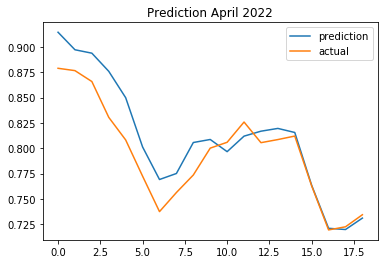

1/1 [==============================] - 0s 292ms/step


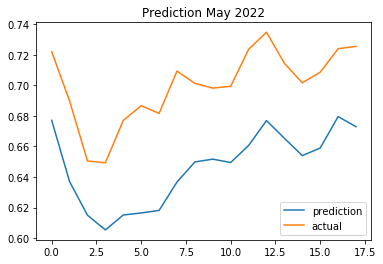

1/1 [==============================] - 0s 290ms/step


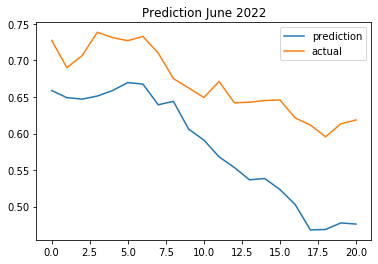

1/1 [==============================] - 0s 389ms/step


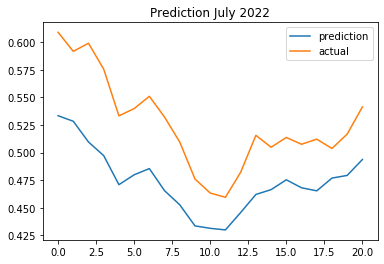

1/1 [==============================] - 0s 391ms/step


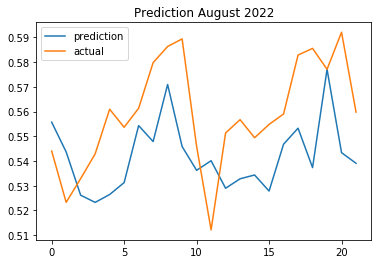

1/1 [==============================] - 0s 414ms/step


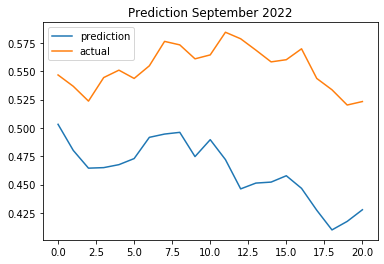

1/1 [==============================] - 0s 309ms/step


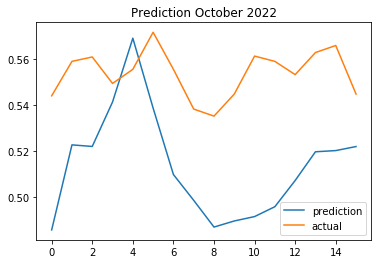

1/1 [==============================] - 0s 373ms/step


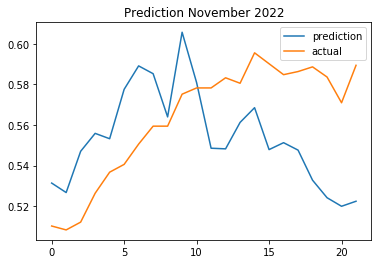

1/1 [==============================] - 0s 304ms/step


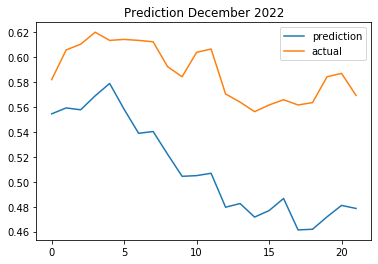

1/1 [==============================] - 0s 297ms/step


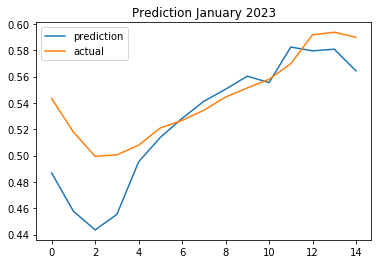

1/1 [==============================] - 0s 298ms/step


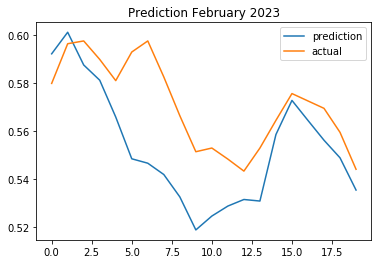

1/1 [==============================] - 0s 294ms/step


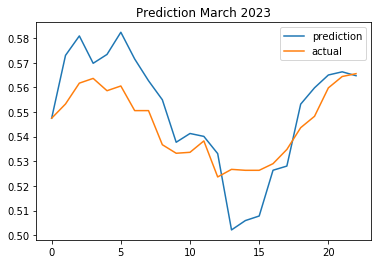

1/1 [==============================] - 0s 292ms/step


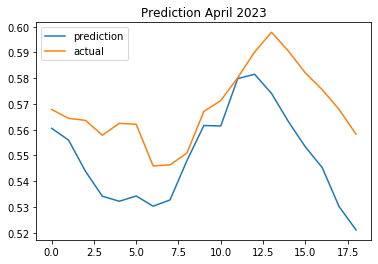

In [52]:
# Parameters for each month
predictions = [
    (19, 1372, 'April 2022', y_scaled[0]),
    (18, 1392, 'May 2022', y_scaled[1]),
    (21, 1410, 'June 2022', y_scaled[2]),
    (21, 1431, 'July 2022', y_scaled[3]),
    (22, 1453, 'August 2022', y_scaled[4]),
    (21, 1475, 'September 2022', y_scaled[5]),
    (16, 1496, 'October 2022', y_scaled[6]),
    (22, 1512, 'November 2022', y_scaled[7]),
    (22, 1534, 'December 2022', y_scaled[8]),
    (15, 1557, 'January 2023', y_scaled[9]),
    (20, 1572, 'February 2023', y_scaled[10]),
    (23, 1592, 'March 2023', y_scaled[11]),
    (19, 1615, 'April 2023', y_scaled[12]),
]

# Iterate through predictions and plot
for day_pred_diff, start_day, month, y in predictions:
    lstm_predictions = lstm_new(day_pred_diff=day_pred_diff, start_day=start_day)
    plt.plot(np.arange(len(lstm_predictions)), lstm_predictions, label="prediction")
    plt.plot(np.arange(len(y)), y, label="actual")
    plt.legend()
    plt.title(f'Prediction {month}')
    plt.show()

**Additional Information on the Cheapest Monthly Point**

In [94]:
lstm_predictions=[y for _, _, _, y in predictions]
y_lstm = [series.tolist() for series in lstm_predictions] #extract forecasted al_price in each month

LSTM_Min=[]
for values, df in zip(y_lstm, test_real):

    min_value = min(values)
    min_index = values.index(min_value)
    corresponding_date = df.iloc[min_index]['DATE']
    corresponding_price = df.iloc[min_index]['AL_PRICE']
    LSTM_Min.append(corresponding_price)
    print(f'lstm identified best date is {corresponding_date}, corresponding AL_PRICE in test_real: {corresponding_price}')

**Calculate Costs**

In [126]:
# Under This Scenario: 
monthly_demand= 216.437 #Assumption:constant monthly demand
arbitrary_strategy_annual_cost=sum(value * monthly_demand for value in LSTM_Min[0:12])#from 2022-03-31 to 2023-03-31
print(f"Arbitrary strategy annual spending:", arbitrary_strategy_annual_cost)

arbitrary_strategy_unit_cost=sum(value * monthly_demand for value in LSTM_Min[0:12])/monthly_demand/12
print(f"Arbitrary strategy unit procurement cost:", arbitrary_strategy_unit_cost)

Strategy 2 annual spending: 48053342.74


**Results**
- The expected annual cost for procuring the same amount of aluminium is 48.05M CHY
- The unit cost is 18,502 CHY/ton

### 3. Refined Strategy

A pusedo-code is shared below to illustrate the logic behind this approach (reader is advised to skip the coding section)

on each candidate date (candidate date referring to date on which we consider al purchase)

**Part 1 - Locating candidate day**
- 1.1: use al pricing prediction engine to predict prices for the next 22 days
- 1.2: group together first 10 days and the next 10 days (ignoring the 2 day at the end), name it group A & B
    - 1.2.1: within each group, compute the date on which we have the lowest predicted al price, be it
    - 1.2.2: 


How to figure out candidate trading day - 2023-07-26
1. 2023-07-26
    1.1 22 day prediction - group into 2 10-ten days group
            10-ten days:
                Group A: candidate day - 2023-08-07
                Group B: candidate day - 2023-08-12
3. when the time goes to 2023-08-07
- Step 1. look at my stock level 2023-08-07
2. if stock < 121: 
        decision: buy
    if stock >= 121:
        3. compute slope - trend in the next 22 days
        4. compute price difference between:
            A. price of current re-stocking candidate date
            B. price of the next re-stocking candidate date, based on trained model up until today
        5. if trend in 3 goes up and 4.B is larger than 4.A then:
              6.1 restock to 300 + (Date(A) - Date(B))*7 
              or if stock larger than above, we buy (Date(A) - Date(B))*7
           else:
              6.2 do nothing

2. 2023-07-26 previous candidate date (any candidate date)



2023-08-07:
    1.1 22 day prediciton - group into 2 10-ten group
        Group A: candidate day - 2023-08-13
        Group B: candidate day - 2023-08-17


2023-08-13:
    1.0 buy or do nothing indicator
    1.1 22 day prediciton - group into 2 10-ten group
        Group A: candidate day - 2023-08-18
        Group B: candidate day - 2023-08-22

- Objective: fit a simple linear regression model to every 22 data points in a given time series. This will involve using a straight line equation y=a+bx, where y is the dependent variable, x is the independent variable, a is the intercept, and b is the slope of the line.
- Result: For each 22-day window, obtain the slope b and the correlation coefficient for the fit.

How the Result is Updated: By rolling through the series and fitting this model to every 22 figures, form a new series of slope values b.

**Re-use the LSTM Model from AL Pricing Engine (PLEASE SKIP)**
>A Quick/Dirty Version is Provided Here, more organised LSTM model pipeline can be found in the repo

In [ ]:
#trains an LSTM model and makes predictions for a specified number of future days
def lstm_pred_day(day_pred_diff, additional_day = 0):
    train_df = scaled_cleaned_data.head(978+additional_day).drop('DATE',axis=1).copy()
    x_train = train_df.loc[:, train_df.columns != 'AL_PRICE'].copy()
    y_train = train_df['AL_PRICE'].copy()
    x_train = tf.convert_to_tensor(x_train.to_numpy())
    x_train = tf.expand_dims(x_train, 1)
    y_train = tf.convert_to_tensor(y_train.to_numpy())
    
    
    # Create the LSTM model
    model = Sequential()
    model.add(LSTM(64))  
    model.add(Dense(4))  
    model.add(Dense(1)) 
    
    # Compile the model
    model.compile(optimizer='adam', loss='mse')

    # Train the model
    model.fit(x_train, y_train, epochs=100, batch_size=32, verbose=0)

    # Predict
    prediction_starting_time = 1000-22+additional_day
    prediction_end_time = day_pred_diff + 1000-22 + additional_day
    temporary_test_dataframe = scaled_cleaned_data.iloc[prediction_starting_time:prediction_end_time].drop('DATE',axis=1).copy()
    x_test = temporary_test_dataframe.loc[:, temporary_test_dataframe.columns != 'AL_PRICE'].copy()
    x_test = tf.convert_to_tensor(x_test.to_numpy())
    x_test = tf.expand_dims(x_test, 1)
    
    lstm_results = model.predict(x_test)
    lstm_results_in_list = [i[0] for i in lstm_results]

    
    return lstm_results_in_list

**Prediction in a 22-day Rolling Window**

In [161]:
%%capture

out = []
day_pred_diff =22
for i, day in enumerate(np.arange(0,631,day_pred_diff)):
    print(i)
    out.append(lstm_pred_day(day_pred_diff = day_pred_diff, additional_day = day))
refined_strategy_lstm_results = np.concatenate(out)

0
1/1 [==============================] - 0s 294ms/step
1
1/1 [==============================] - 0s 316ms/step
2
1/1 [==============================] - 0s 307ms/step
3
1/1 [==============================] - 0s 290ms/step
4
1/1 [==============================] - 0s 329ms/step
5
1/1 [==============================] - 0s 455ms/step
6
1/1 [==============================] - 0s 298ms/step
7
1/1 [==============================] - 0s 324ms/step
8
1/1 [==============================] - 0s 312ms/step
9
1/1 [==============================] - 0s 299ms/step
10
1/1 [==============================] - 0s 332ms/step
11
1/1 [==============================] - 0s 307ms/step
12
1/1 [==============================] - 0s 310ms/step
13
1/1 [==============================] - 0s 324ms/step
14
1/1 [==============================] - 0s 315ms/step
15
1/1 [==============================] - 0s 309ms/step
16
1/1 [==============================] - 1s 690ms/step
17
1/1 [==============================] - 0s 310ms/step
18

**Compute Trend For The Next 22 Days of Trading Day (Based on AL Pricing Prediction Engine)**

- This is to see if there is a upward or downward trend in the aluminium prices in the aluminium price prediction from next 22 trading days

In [163]:
def compute_slopes_and_correlations(series):
    window_size = 22
    slopes = []
    correlation_coeffs = []

    # Rolling through the series with a window of 22
    for i in range(len(series) - window_size + 1):
        window = series[i:i + window_size]
        x = np.arange(window_size)

        # Using linear regression to compute slope, intercept, and correlation coefficient
        slope, intercept, r_value, _, _ = linregress(x, window)

        slopes.append(slope)
        correlation_coeffs.append(r_value**2)

    return slopes, correlation_coeffs

slopes, correlation_coeffs = compute_slopes_and_correlations(refined_strategy_lstm_results[394:638]) #394 is the 2022-03-31
# Creating a DataFrame with slopes and correlation_coeffs
slopes = pd.DataFrame({
    'Slopes': slopes,
    'Correlation_Coefficients': correlation_coeffs
})

# Extract true values of the same period from 2022-03-31 to 2023-03-31
slope_test_true_set=cleaned_data[1372:1616].reset_index(drop=True)
slope_test_predicted_set=pd.DataFrame({'Prediction':refined_strategy_lstm_results[394:638]})
slope_test_predicted_set['True']=slope_test_true_set['AL_PRICE']
slope_test_predicted_set['DATE']=slope_test_true_set['DATE']
slope_test_predicted_set['Slope']=slopes['Slopes']

#drop null values
slope_test_set=slope_test_predicted_set.dropna()
slope_test_set.columns = slope_test_set.columns.str.upper()

#preview
slope_test_set.head(5)

Create a function that rolls over the DataFrame every 22 rows 
and extracts the row with the lowest prediction only if the corresponding slope is 1

In [169]:
def encode_values(value):
    # encode slopes
    if value > 0:
        return 1
    elif value < 0:
        return -1
    else:
        return 0

def get_min_prediction_rows(df, freq):
    # Resample
    min_pred_idx = df.resample(freq)['PREDICTION'].idxmin()
    min_pred_rows = df.loc[min_pred_idx]

    min_pred_rows['SLOPE_2'] = np.sign(min_pred_rows['PREDICTION'].pct_change()).shift(-1)
    min_pred_rows['DECISION'] = min_pred_rows['SLOPE'] + min_pred_rows['SLOPE_2']
    
    # Apply a transformation
    min_pred_rows['DECISION'] = min_pred_rows['DECISION'].apply(lambda x: 1 if x == 2 else 0)
    
    return min_pred_rows.reset_index()

slope_test_set['SLOPE'] = slope_test_set['SLOPE'].apply(encode_values)
slope_test_set_copy = slope_test_set.copy()
slope_test_set_copy['DATE'] = pd.to_datetime(slope_test_set_copy['DATE'])
slope_test_set_copy.set_index('DATE', inplace=True)

# Get the result for each desired frequency
#min_pred_rows_per_month = get_min_prediction_rows(slope_test_set_copy, 'M')
#min_pred_rows_per_15D = get_min_prediction_rows(slope_test_set_copy, '15D')
min_pred_rows_per_10D = get_min_prediction_rows(slope_test_set_copy, '10D')

In [170]:
# Calculate the difference between consecutive dates
min_pred_rows_per_10D['DAYS_DIFF']=min_pred_rows_per_10D['DATE'].diff().dt.days

In [171]:
# We can manually calculate the difference between 2022-03-31 and 2022-04-08
min_pred_rows_per_10D['DAYS_DIFF']=min_pred_rows_per_10D['DAYS_DIFF'].fillna(8)

In [172]:
refined_strategy_dataset=min_pred_rows_per_10D.copy()

In [173]:
# Create new columns for restocking information
refined_strategy_dataset['RESTOCKING_DATE'] = False
refined_strategy_dataset['RESTOCKED_AMOUNT'] = 0.0

# Start with the first row's stock level
stock_level = 300 - 7 * refined_strategy_dataset.loc[0, 'DAYS_DIFF']
refined_strategy_dataset.loc[0, 'STOCK_LEVEL'] = stock_level

# Iterate through the remaining rows
for i in range(1, len(refined_strategy_dataset) - 1): # Modified loop range to exclude last row
    # Continue decreasing the stock level by 7 times the current row's DAYS_DIFF
    stock_level -= 7 * refined_strategy_dataset.loc[i, 'DAYS_DIFF']
    
    restocked_amount = 0 # Initialize restocked amount
    
    # Check for re-stock conditions
    if refined_strategy_dataset.loc[i, 'DECISION'] == 1:
        restocked_amount = 7 * refined_strategy_dataset.loc[i+1, 'DAYS_DIFF']
        stock_level = 300 + restocked_amount
    
    elif stock_level <= 121:
        restocked_amount = 7 * refined_strategy_dataset.loc[i+1, 'DAYS_DIFF']
        stock_level = stock_level + restocked_amount

    # Update restocking information in the DataFrame
    if restocked_amount > 0:
        refined_strategy_dataset.loc[i, 'RESTOCKING_DATE'] = True
        refined_strategy_dataset.loc[i, 'RESTOCKED_AMOUNT'] = restocked_amount

    # Update the stock level in the DataFrame
    refined_strategy_dataset.loc[i, 'STOCK_LEVEL'] = stock_level

# Handle the last row separately to avoid index error
i = len(refined_strategy_dataset) - 1
stock_level -= 7 * refined_strategy_dataset.loc[i, 'DAYS_DIFF']
refined_strategy_dataset.loc[i, 'STOCK_LEVEL'] = stock_level


In [185]:
refined_strategy_dataset.to_csv("strategy_3_data")

In [177]:
restocking = refined_strategy_dataset[refined_strategy_dataset['RESTOCKING_DATE']==True]
restocking['PROCUREMENT']=restocking['TRUE']*restocking['RESTOCKED_AMOUNT']

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [187]:
restocking.to_csv("restocking")

**Results**

In [179]:
# restocking value from 2022-03-31 to 2023-02-13
restocking.PROCUREMENT.sum()

21333235.0

In [180]:
# restocking amount from 2022-03-31 to 2023-02-13
restocking.RESTOCKED_AMOUNT.sum()

1141.0

In [191]:
refined_strategy_unit = restocking.PROCUREMENT.sum()/restocking.RESTOCKED_AMOUNT.sum()
refined_strategy_annual = (restocking.PROCUREMENT.sum()/restocking.RESTOCKED_AMOUNT.sum())*monthly_demand*12
print(f"Refined Strategy unit procurement cost:", refined_strategy_unit)
print(f"Refined Strategy annual spending:", refined_strategy_annual)